In [ ]:
#This notebook is designed to be converted to a HTML slide show
#To do this in the command prompt type (in the folder containing the notebook): 
#       jupyter nbconvert *.ipynb --to slides

# Bioscrape Lineages
## William Poole
## SB-tools Bootcamp 06-23-2020
__Overview:__ In this workshop, we will see how ensembles of stochastic CRNs can be simulated as growing, dividing, and interacting cells using [Bioscrape Lineages](https://github.com/biocircuits/bioscrape).

## What Is Bioscrape?

### Biological Circuit Stochastic Simulation of Single Cell Reactions and Parameter Estimation

Bioscrape is python software to simulate CRNs deterministically or stochastically
* Also does parameter inference and simulates single cells....to be discussed tomorrow.
* You can do tons of simulations very quickly to explore parameter space or large numbers of potential circuits
* Uses Cython (special python code that compiles into C)
* Multiple highly optimized simulators
* So far BioCRNpyler simulations have all used Bioscrape under the hood.


### Bioscrape is FAST! 

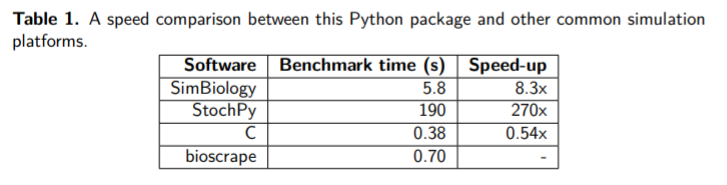

_The benchmark test used for comparing the speed of these different simulators is a simple gene expression model consisting of just four stochastic reactions: transcription, translation, and degradation of mRNA and protein._

# What is Bioscrape Lineages?
A package built on top of Bioscrape to simulate individual cells which grow, divide, die, and interact.

_Next we will briefly go through how Bioscrape Lineages works and build a Lineage Model_.

# Switch to LineagesBeta Branch
CD to Bioscrape Directory
> git checkout origin/LineageBeta

> python setup.py install

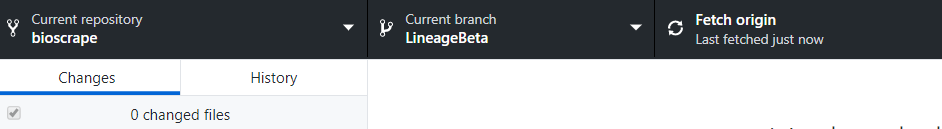

### Create a Model Similar to the Signalling Model explored above, but with production of Machinery and no degredation of proteins (this will happen via dilution).

In [19]:
from biocrnpyler import *
import pylab as plt
import numpy as np

#Create Species for this model
S = Species("S")
F0 = Species("F0")
F1 = ComplexSpecies([S, S, F0])
G0 = Species("G0")
G1 = ComplexSpecies([F1, G0])
P = Species("P")
G1P = ComplexSpecies([G1, P])
T = Species("T")
Ri = Species("R")
TR = ComplexSpecies([T, Ri])
X = Species("X")
species = [S, F0, F1, G0, G1, P, G1P, T, Ri, TR, X]

#Create Reactions for this model
ku = 10
kb = 100
ktx = .9
ktl = 5
kdil = .1
kR = 10
kP = 2
kF = 1.5
rxn1 = Reaction([S, S, F0], [F1], k = kb, k_rev = ku) #2S + F0 <--> F1
rxn2 = Reaction([F1, G0], [G1], k = kb, k_rev = ku) #F1 + G0 <--> G1
rxn3 = Reaction([G1, P], [G1P], k = kb, k_rev = ku) #G1 + P <--> G1P
rxn4 = Reaction([T, Ri], [TR], k = kb, k_rev = ku) #T + R <--> TR
rxntx = Reaction([G1P], [G1, P, T], k = ktx) #Transcription
rxntl = Reaction([TR], [T, Ri, X], k = ktx) #Transcription
rxndt = Reaction([T], [], k = kdil) #T-->0
#Creation Reaction to Replenish Machinery
rxnR = Reaction([], [Ri], k = kR) #0 --> R
rxnP = Reaction([], [P], k = kP) #0 --> P
rxnF = Reaction([], [F0], k = kF) # 0 -->F0
reactions = [rxn1, rxn2, rxn3, rxn4, rxntx, rxntl, rxndt, rxnR, rxnP, rxnF]
CRN = ChemicalReactionNetwork(species = species, reactions = reactions)
CRN.write_sbml_file("DetailedSignalling.xml")

#An initial condition for each species (uninitialized species default to 0)
x0 = {
    str(S):200,
    str(F0):10,
    str(G0):1,
    str(P):25,
    str(Ri):100,
}

print(CRN.pretty_print())

Species (11) = {0. S, 1. F0, 2. complex[F0:2x_S], 3. G0, 4. complex[G0:complex[F0:2x_S]], 5. P, 6. complex[P:complex[G0:complex[F0:2x_S]]], 7. T, 8. R, 9. complex[R:T], 10. X}
Reactions (10) = [
0. 2 S + F0 <--> complex[F0:2x_S]        
        massaction: k_f(S,F0)=100*S^2*F0
        k_r(complex[F0:2x_S])=10*complex[F0:2x_S]
1. complex[F0:2x_S] + G0 <--> complex[G0:complex[F0:2x_S]]        
        massaction: k_f(complex[F0:2x_S],G0)=100*complex[F0:2x_S]*G0
        k_r(complex[G0:complex[F0:2x_S]])=10*complex[G0:complex[F0:2x_S]]
2. complex[G0:complex[F0:2x_S]] + P <--> complex[P:complex[G0:complex[F0:2x_S]]]        
        massaction: k_f(complex[G0:complex[F0:2x_S]],P)=100*complex[G0:complex[F0:2x_S]]*P
        k_r(complex[P:complex[G0:complex[F0:2x_S]]])=10*complex[P:complex[G0:complex[F0:2x_S]]]
3. T + R <--> complex[R:T]        
        massaction: k_f(T,R)=100*T*R
        k_r(complex[R:T])=10*complex[R:T]
4. complex[P:complex[G0:complex[F0:2x_S]]] --> complex[G0:complex[F0:2x_

## Below is the entire construction of the Lineage Model used in the following Simulations. This is also shown step-by-step later in the notebook.

/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/bioscrape/sbmlutil.py:208: UserWarning: Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. Refer to the bioscrape wiki for more information.
  warnings.warn('Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. ' +


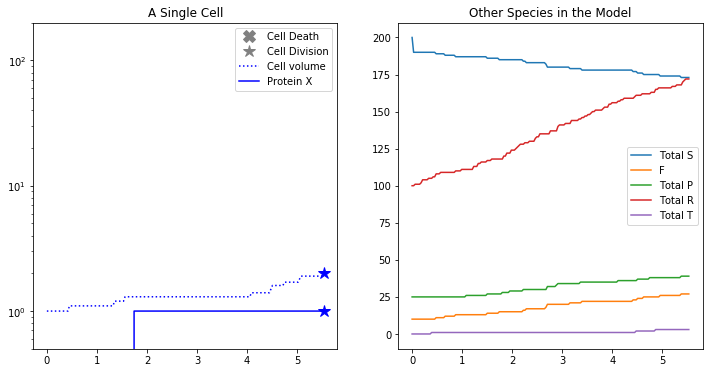

In [20]:
from bioscrape.lineage import LineageModel, LineageVolumeSplitter, py_SimulateSingleCell
M = LineageModel(initial_condition_dict = x0, sbml_filename = "DetailedSignalling.xml")

vsplit_options = {
    "default":"binomial",
    str(G0):"duplicate",
    str(G1):"duplicate",
    str(G1P):"duplicate"
}

vsplit = LineageVolumeSplitter(M, options = vsplit_options)

delta = 1
M.create_division_rule("deltaV", {"threshold":delta}, vsplit)
g = .1
kgrow = .012
M.create_volume_event("linear volume", {"growth_rate":g}, "massaction", {"k":kgrow, "species":str(Ri)})
kdeath = .08
Kdeath = 25
M.create_death_event("death", {}, "hillpositive", {"k":kdeath, "s1":str(X), "n":2, "K":Kdeath})
M.py_initialize()


tmax = 30
timepoints = np.linspace(0, tmax, 1000)
ymin = .5
ymax = 200
ms = 12

R = py_SimulateSingleCell(timepoints, Model = M)

#plotting
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.plot(0, 0, "X", ms = ms, color = "grey", label = "Cell Death")
plt.plot(0, 0, "*", ms = ms, color = "grey", label = "Cell Division")
plt.plot(R["time"], R["volume"], ":", label = "Cell volume", color = (0, 0, 1))
plt.plot(R["time"], R[str(X)], label = "Protein X", color = (0, 0, 1))

plt.plot(R["time"][len(R["time"])-1], R["X"][len(R["X"])-1], "*", ms = ms, color = (0, 0, 1))
plt.plot(R["time"][len(R["time"])-1], R["volume"][len(R["volume"])-1], "*", ms = ms, color = (0, 0, 1))

plt.yscale('log')
plt.ylim(ymin, ymax)
plt.legend()
plt.title("A Single Cell")

plt.subplot(122)
plt.title("Other Species in the Model")
plt.plot(R["time"], R[str(S)]+R[str(F1)]+R[str(G1)]+R[str(G1P)], label = "Total S")
plt.plot(R["time"], R[str(F0)]+R[str(F1)]+R[str(G1)]+R[str(G1P)], label = "F")
plt.plot(R["time"], R[str(P)]+R[str(G1P)], label = "Total P")
plt.plot(R["time"], R[str(Ri)]+R[str(TR)], label = "Total R")
plt.plot(R["time"], R[str(T)]+R[str(TR)], label = "Total T")
plt.legend()


# Single Cells are Individual Stochastic CRNs
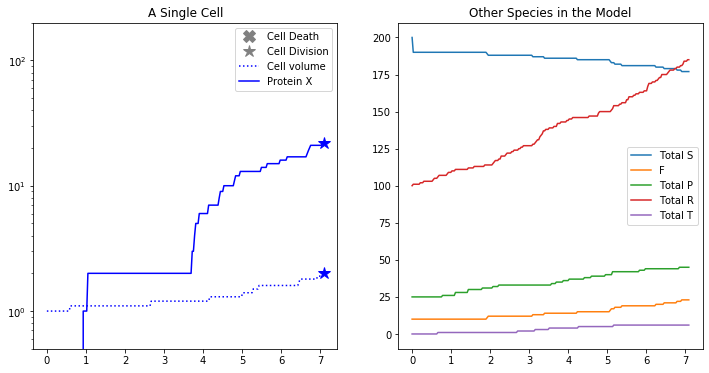

Text(0.5, 1.0, 'Non-interactinc Cells')

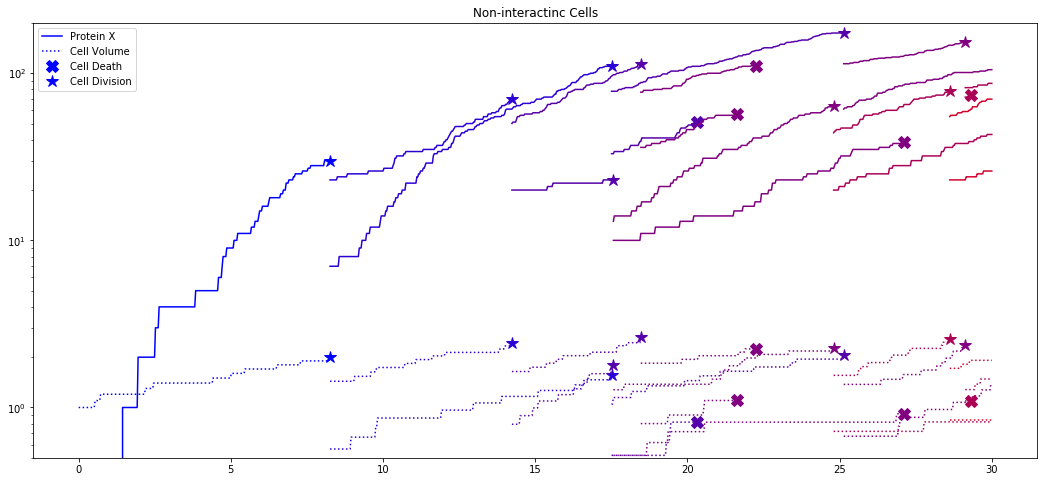

In [21]:
#Simulate a Non-interacting Lineage
from bioscrape.lineage import py_SimulateCellLineage

lineage = py_SimulateCellLineage(timepoints, Model = M)
sch_tree = lineage.get_schnitzes_by_generation()
color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]

#Plotting
plt.figure(figsize = (18, 8))
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch_ind in range(len(L)):
        sch = L[sch_ind]
    
        df = sch.py_get_dataframe(Model = M)
        
        
        if sch_ind == 0 and generation == 0:
            plt.plot(df["time"], df["X"], color = color_list[generation], label = "Protein X")
            plt.plot(df["time"], df["volume"], ":", color = color_list[generation], label = "Cell Volume")
        else:
            plt.plot(df["time"], df["X"], color = color_list[generation])
            plt.plot(df["time"], df["volume"], ":", color = color_list[generation])
        
        dead = sch.py_get_daughters()[0] is None and df["time"][len(df["time"])-1] < timepoints[-1]
        divided = sch.py_get_daughters()[0] is not None and df["time"][len(df["time"])-1] < timepoints[-1]
        
        if dead:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "X", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df["X"][len(df["X"])-1], "X", ms = ms, color = color_list[generation])
        if divided:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "*", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df["X"][len(df["X"])-1], "*", ms = ms, color = color_list[generation])

plt.plot(0, 0, "X", ms = ms, color = color_list[0], label = "Cell Death")
plt.plot(0, 0, "*", ms = ms, color = color_list[0], label = "Cell Division")
plt.yscale('log')
plt.ylim(ymin, ymax)
plt.legend()
plt.title("Non-interactinc Cells")


# Non-interacting Lineage Simulation are many SSA Trajectories Connected by Division Events

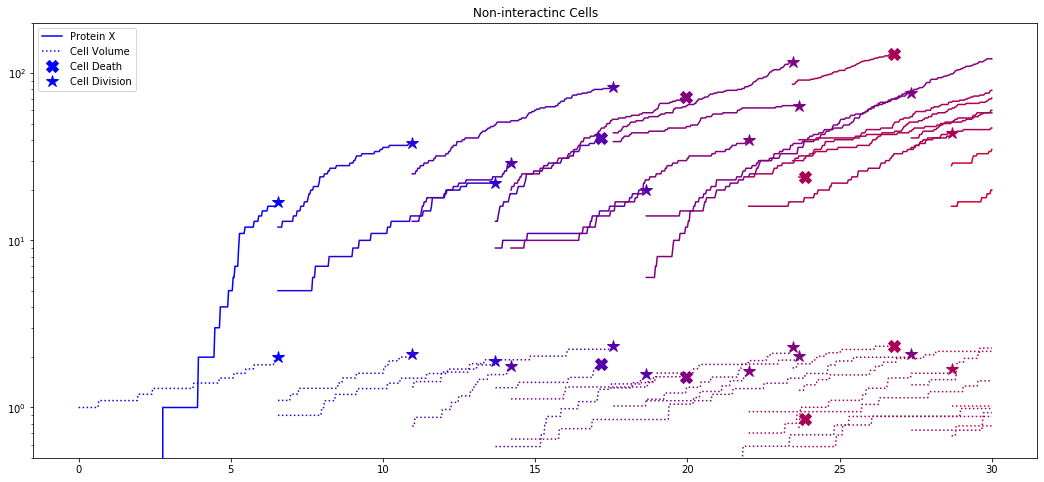

/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following species are uninitialized and their value has been defaulted to 0: X, 
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Cells Exchanging X with Each Other and the Enviornment')

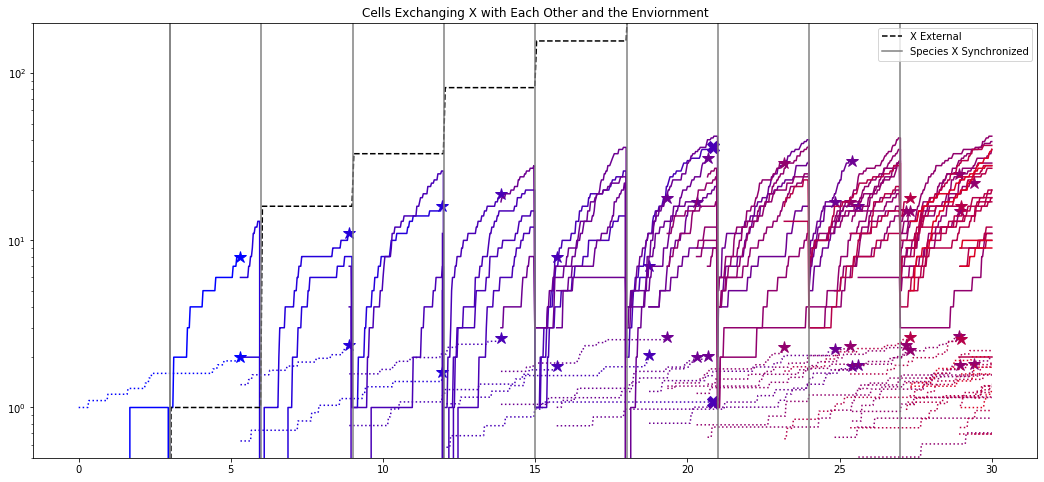

In [22]:
from bioscrape.lineage import py_SimulateInteractingCellLineage
from bioscrape.types import Model

global_sync_period = 3
global_volume = 150
average_dist_threshold = 5
initial_cell_counts = [1]

global_species = [str(X)]
#Could load another SBML Model for the Environment!
global_crn = Model(species = global_species)

lineage_list, global_results, simulator = py_SimulateInteractingCellLineage(timepoints, global_sync_period, 
                                                                            global_volume = global_volume, 
                                                                            model_list = [M],
                                                                            initial_cell_states = initial_cell_counts,
                                                                            global_species = global_species,
                                                                            global_volume_model = global_crn,
                                                                            average_dist_threshold = average_dist_threshold)

lineage_interacting = lineage_list[0]
sch_tree = lineage_interacting.get_schnitzes_by_generation()
color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]

plt.figure(figsize = (18, 8))
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch_ind in range(len(L)):
        sch = L[sch_ind]
    
        df = sch.py_get_dataframe(Model = M)
        plt.plot(df["time"], df["volume"], ":", color = color_list[generation])
        
        plt.plot(df["time"], df[str(X)], color = color_list[generation])
        
        dead = sch.py_get_daughters()[0] is None and df["time"][len(df["time"])-1] < timepoints[-1]
        divided = sch.py_get_daughters()[0] is not None and df["time"][len(df["time"])-1] < timepoints[-1]
        
        if dead:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "X", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df[str(X)][len(df[str(X)])-1], "X", ms = ms, color = color_list[generation])
        if divided:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "*", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df[str(X)][len(df[str(X)])-1], "*", ms = ms, color = color_list[generation])

df_global = global_results.py_get_dataframe(Model = global_crn)
plt.plot(df_global["time"], df_global[str(X)], "--", label = "X External", color = "black")

for i in range(global_sync_period, tmax, global_sync_period):
    if i == global_sync_period:
        plt.plot([i, i], [ymin, ymax], color = "grey", label = "Species X Synchronized")
    plt.plot([i, i], [ymin, ymax], color = "grey")

plt.yscale('log')
plt.ylim(ymin, ymax)
plt.legend()
plt.title("Cells Exchanging X with Each Other and the Enviornment")

# Interacting Cells are many SSA trajectories simulated independently and synchronized by remixing global species every $\Delta T$ time

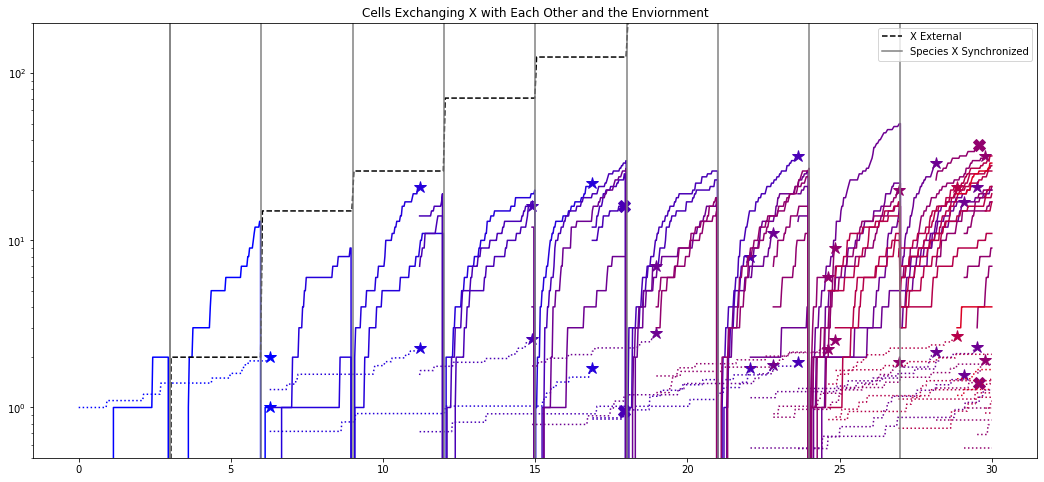

# Running a Lineage Simulation

## 1. Create a Lineage Model from an SBML CRN

In [23]:
from bioscrape.lineage import LineageModel, LineageVolumeSplitter

#Load an SBML Model Generated from BioCRNpyler
M = LineageModel(initial_condition_dict = x0, sbml_filename = "DetailedSignalling.xml")

/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/bioscrape/sbmlutil.py:208: UserWarning: Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. Refer to the bioscrape wiki for more information.
  warnings.warn('Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. ' +


## 2. Use Volume Rules and/or Volume Events to Model Cell Growth

### Volume Rules are Deterministic:
* __"linear"__ (for linear growing volume)
* __"multiplicative"__ (for exponentially growing volume)
* __"assignment"__ where the volume is set to any function (key "equation")
* __"ode"__ where $\frac{dV}{dt} = F(state, time)$ is integrated with Eulers method

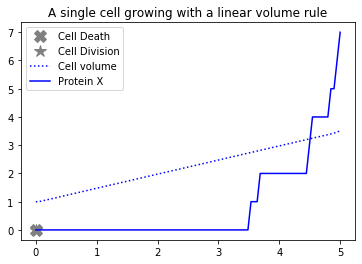

In [24]:
g = .25
M.create_volume_rule("linear", {"growth_rate":g});

### Volume Events are Stochastic (Can occur with any propensity type)
* __"linear"__ (for linear growing volume)
*  __"multiplicative"__ (for exponentially growing volume)
* __"general"__ where the volume is set to any function (key "equation")

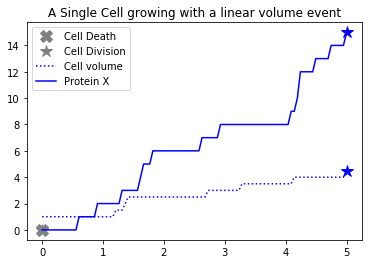

In [25]:
#Events require propensities (any of the types available in BioCRNpyler work) and propensity parameters.
M.create_volume_event("linear volume", {"growth_rate":g}, "massaction", {"k":.012, "species":str(Ri)});

# Create a Division Rule(s) and/or a Division Event(s) and Volume Splitters

### Division Rules cause Cells will divide deterministically 

* "__deltaV__" whenever they have grown by an amount $\Delta$ (key "threshold")
* "__time__" where a cell will divide ever $T$ time (key "threshold"). 
* "__volume__" where a cell will divide at some volume threshold (key "threshold").
* "__general__" where a cell divides if a general algebraic expression (key "equation") is greater than 0.

### Division Events cause cells to divide stochastically
* Rate is given by the event propensity

### VolumeSplitter objects determine how different Species and volume are partitioned between daughter cells
* dupliate
* perfect (even division)
* binomial (default)
Each division rule or event may have its own, unique, volume splitter

In [26]:
#Create a Volume Splitter
vsplit_options = {
    "default":"binomial",
    str(G0):"duplicate",
    str(G1):"duplicate",
    str(G1P):"duplicate"
}

vsplit = LineageVolumeSplitter(M, options = vsplit_options)

In [27]:
M.create_division_rule("deltaV", {"threshold":1}, vsplit)

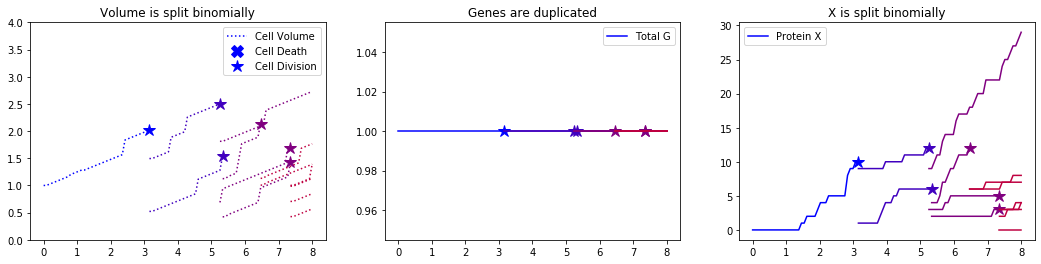

# Create Death Rule(s) and/or Event(s)

### Death Rules Kill Cells Deterministically
* "__species__" where the cell will die if a certain species (key "species") is ">", "<", or "=" (key "comp") to a threshold (key "threshold").
* "__param__" which is like a species death rule, but for a certain parameter (key "param").
* "__general__" which is like a general division rule.

### Death Events Kill Cells Stochastically
* Rate can be any propensity function

In [28]:
M.create_death_event("death", {}, "hillpositive", {"k":.25, "s1":str(X), "n":2, "K":10})

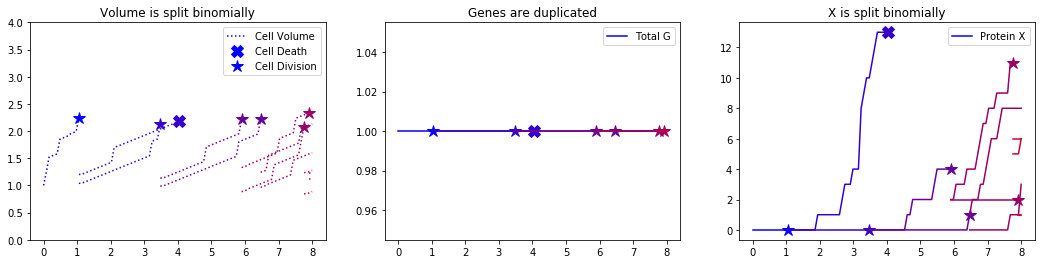

# After a LineageModel is made, it must be initialized

In [29]:
M.py_initialize()

# The Model is ready to be simulated if Cells don't interact

In [30]:
timepoints = np.linspace(0, 30, 1000)
lineage = py_SimulateCellLineage(timepoints, Model = M) #Used for simulating non-interacting lineages

Total Cells Simulated =  1757 
Cells of each generation: [1, 2, 2, 4, 8, 14, 24, 44, 76, 126, 216, 348, 404, 322, 142, 20, 4]
Plotting


No handles with labels found to put in legend.


Text(0, 0.5, 'Protein X')

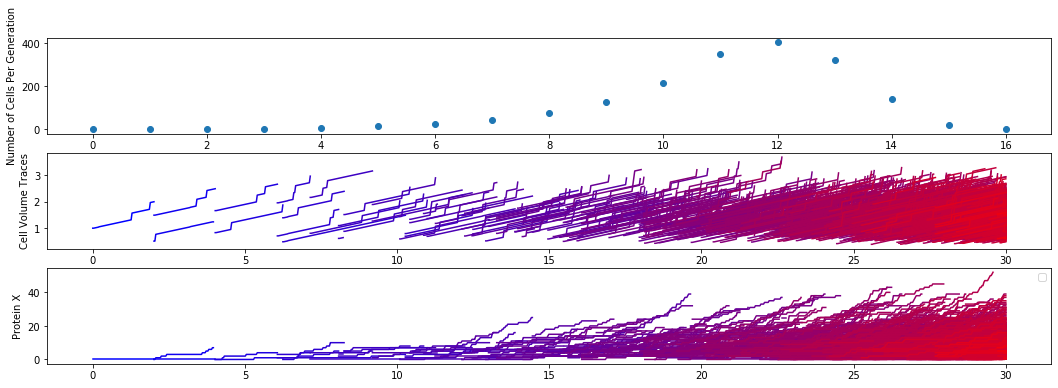

In [31]:
# A little plotting
#For analysis and plotting purposes, it can be effective to use the function get_schnitzes_by_generation
#this returns a list of lists where the ith entry is a list of all Schnitzes of generation i
sch_tree = lineage.get_schnitzes_by_generation()
print("Total Cells Simulated = ", sum([len(L) for L in sch_tree]),"\nCells of each generation:", [len(L) for L in sch_tree])

color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]

print("Plotting")
plt.figure(figsize = (18, 6))
#Plot Generation Counts
plt.subplot(311)
plt.plot(range(len(sch_tree)), [len(L) for L in sch_tree], "o")
plt.ylabel("Number of Cells Per Generation")

#Plot Volume Traces
plt.subplot(312)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch in L:
        df = sch.py_get_dataframe(Model = M)
        plt.plot(df["time"], df["volume"], color = color_list[generation])
plt.ylabel("Cell Volume Traces")

#Plot lacI
plt.subplot(313)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch in L:
        df = sch.py_get_dataframe(Model = M)
        plt.plot(df["time"], df[str(X)], color = color_list[generation])

plt.legend()
plt.ylabel("Protein X")

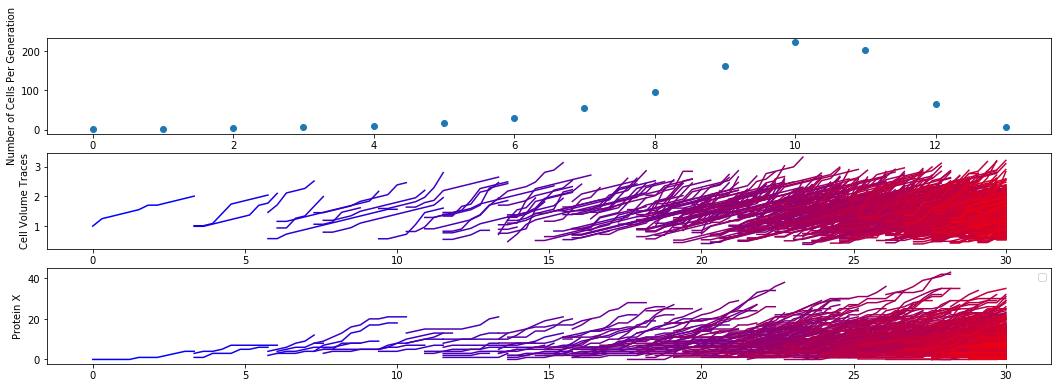

# To make Cells Interact Use py_SimulateInteractingLineage

In [32]:
#Simulation Parameters
global_sync_period = 3.0 #How often to distribute global species
global_volume = 1000 #Is the volume that all the cells are growing. If its 0, there is no external volume.
average_dist_threshold = 5. #when to distribute global species stochastically versus deterministically
global_species = [str(S), str(X)] #Global Species are redistributed between cells and the environment

model_list = [M] #this can take multiple models for different cell types
initial_cell_counts = [1] #Initial cells per model 

In [33]:
#The environment can have a global Model (Note this is not a lineage Model)
from bioscrape.types import Model
Mglobal = Model(species = [str(X), str(S)]) #Could load an SBML model here as well!

/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The following species are uninitialized and their value has been defaulted to 0: X, S, 
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
lineage_list, global_results, simulator = py_SimulateInteractingCellLineage(timepoints, global_sync_period, global_volume = global_volume,
                                                 model_list = model_list, global_volume_model = Mglobal,
                                                 initial_cell_states = initial_cell_counts, 
                                                 global_species = global_species, 
                                                 average_dist_threshold = average_dist_threshold)

/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Total cell volume exceeded global volume. All cells set to dead and simulation terminated.
  """


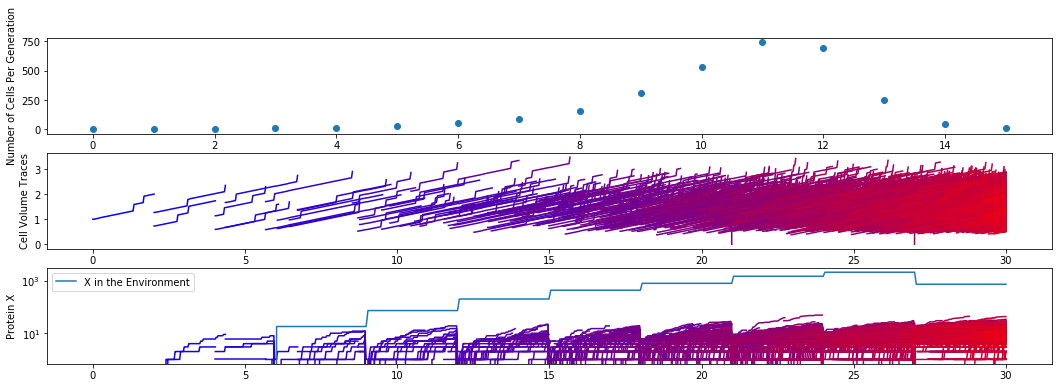

Total Cells Simulated =  2151 
Cells of each generation: [1, 2, 4, 8, 16, 30, 56, 106, 198, 344, 530, 508, 262, 72, 14]
Plotting


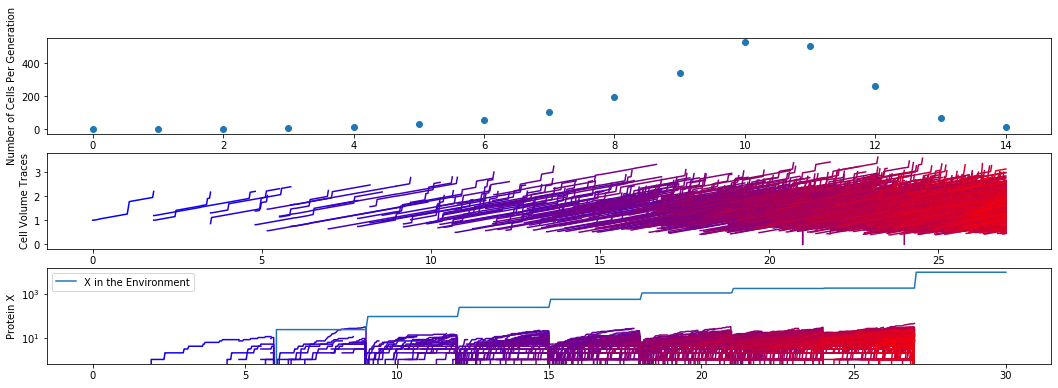

In [35]:
# A little plotting
df_global = global_results.py_get_dataframe(Model = Mglobal) #global_results can be converted to a dataframe
lineage = lineage_list[0] #Lineage list is a list of lineages

#For analysis and plotting purposes, it can be effective to use the function get_schnitzes_by_generation
#this returns a list of lists where the ith entry is a list of all Schnitzes of generation i
sch_tree = lineage.get_schnitzes_by_generation()
print("Total Cells Simulated = ", sum([len(L) for L in sch_tree]),"\nCells of each generation:", [len(L) for L in sch_tree])

color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]

print("Plotting")
plt.figure(figsize = (18, 6))
#Plot Generation Counts
plt.subplot(311)
plt.plot(range(len(sch_tree)), [len(L) for L in sch_tree], "o")
plt.ylabel("Number of Cells Per Generation")

#Plot Volume Traces
plt.subplot(312)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch_i, sch in enumerate(L):
        df = sch.py_get_dataframe(Model = M)
        plt.plot(df["time"], df["volume"], color = color_list[generation])
plt.ylabel("Cell Volume Traces")

#Plot lacI
plt.subplot(313)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch_i, sch in enumerate(L):
        df = sch.py_get_dataframe(Model = M)
        plt.plot(df["time"], df[str(X)], color = color_list[generation])
plt.plot(df_global["time"], df_global[str(X)], label = "X in the Environment")

plt.legend()
plt.ylabel("Protein X")
plt.yscale('log')